# Locality Measure
We want to summarize, how local the covariance is, e.g. how big is the radius around a pixel so the accumulated covariance is below 95%? For this task, we define a covariance matrix $\Sigma$, with a constant variance on the diagonals, while the covariance decreases exponentially in all directions on a regular grid.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import ipywidgets as widgets

In [2]:
def exponential(value, gamma):
    return np.exp( - gamma * value)

def linear(value, gamma):
    return - gamma * value + 1

def get_neigbours_y(p, n, height, width):
    '''
    Get the neighbouring indices of the pixel p along the y-axis within 
    distance n.

    Parameter
    ---------
    p: [int]
        Index of the target pixel.
    n: int
        Distance at whitch the neighbours are considered.
    height: int
        Height of the grid.
    width: int
        Width of the grid.

    Return
    ------
    [int]
        A list of neighbouring indices in ascending order.
    '''

    assert p >= 0, 'The index of the pixel should be poitive or zero' 
    assert (height > 0 or width > 0), 'The height and width should be positive numbers'

    if n < 1:
        return []

    neighbours = []
    # move upwards
    for i in range(1, n+1):
        if p - i * width < 0:
            break
        neighbours.append(p - i * width)

    # ensure ascending order
    neighbours.reverse()

    # move downwards
    for i in range(1, n+1):
        if p + i * width >= width*height:
            break
        neighbours.append(p + i * width)

    return neighbours

def build_covariance_y(variance, function, width=3):
    '''
    Generate a covariance matrix, which covariance is along the 
    y-dimension of a grid.

    Parameter
    ---------
    variance: array_like
        A 2D array of variances for each pixel.
    '''
    
    im_height, im_width = variance.shape
    n = im_height * im_width
    var = np.diagflat(variance.flatten())
    
    for p in range(n):
        idy = get_neigbours_y(p, width, im_height, im_width)
        
        omega = np.arange(0,width+1)
        rho = function(omega, 1/width)
        
        top = 1
        bottom = min(width, p//im_width)
        for idx in idy:
            if p < idx:
                # bottom
                #var[p,idx] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[top]
                var[idx,p] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[top]
                top += 1
            if p > idx:
            #    # top
                var[idx,p] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[bottom]
            #    var[p,idx] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * bottom
                bottom -= 1
            
    return var

# Only positive covariance with linear decay
If we only consider positive covariances, the locality can be formulated as followed:
\begin{align}
    l(p) &= \Sigma_p(q)
\end{align}

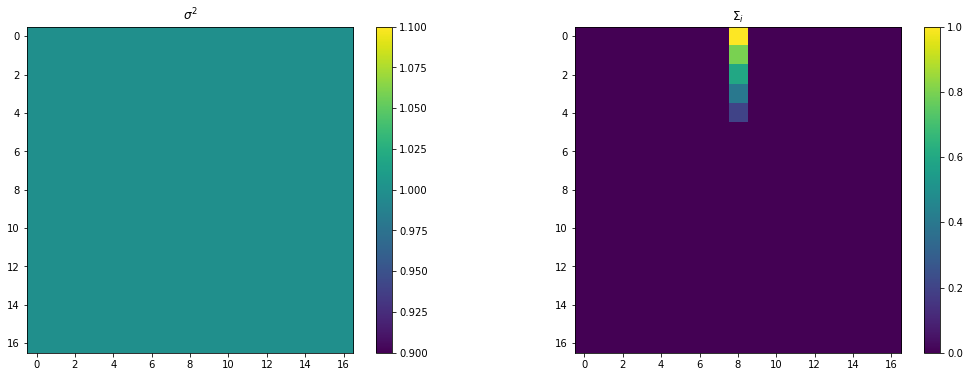

In [40]:
gridDimensions = np.array([17,17])
variance = np.ones(gridDimensions)

Sigma = build_covariance_y(variance, linear, 5)

# center pixel
p = np.array([17//2, 0])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma[targetPixel,:].reshape(gridDimensions)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.imshow(np.diag(Sigma).reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.show()

In [41]:
def dist_covariance(Sigma, idx, percent=0.95):
    n = np.int64(np.sqrt(Sigma.shape[0]))
    Sigma_i = Sigma[idx, :].reshape((n,n))
    pixel = np.array([
        idx % n,
        idx // n
    ])
    
    overallCovariance = Sigma_i.sum()
    width = np.max(Sigma_i.shape) + 1
    for i in range(1, width):
        left = max(0, pixel[0]-i)
        right = min(Sigma_i.shape[0], pixel[0]+i+1)
        top = max(0, pixel[1]-i)
        bottom = min(Sigma_i.shape[1], pixel[1]+i+1)

        subset = Sigma_i[top:bottom, left:right]
        
        #mapping = np.zeros_like(Sigma_i)
        #mapping[top:bottom, left:right] = 1
        #plt.figure()
        #plt.title('{:d} - {:g} < {:g}'.format(i, subset.sum(), percent * overallCovariance))
        #plt.imshow(mapping)
        #ax = plt.gca()
        #ax.set_xticks(np.arange(-.5, n, 1))
        #ax.set_yticks(np.arange(-.5, n, 1))
        #ax.set_xticklabels(np.arange(0, n+1, 1))
        #ax.set_yticklabels(np.arange(0, n+1, 1))
        #ax.grid(color='red', linestyle='-.', linewidth=1)
        #plt.show()
        
        if subset.sum() > percent * overallCovariance:
            # the subset contains now more that `percent` of the overall covariance,
            # thus the previus is below that thresshold
            return i - 1

        if right == Sigma_i.shape[0] and bottom == Sigma_i.shape[1] and left == 0 and top == 0:
            # maximum reached
            return i
    return width

#dist_covariance(Sigma, targetPixel, 0.95)

In [54]:
localityMap = np.array([dist_covariance(Sigma, p, 0.92) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

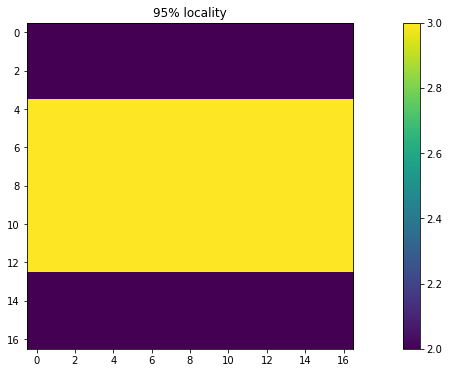

In [55]:
plt.figure(figsize=(18,6))
plt.title('95% locality')
plt.imshow(localityMap)
plt.colorbar()
plt.show()

# Using experimental data

In [57]:
Sigma = np.load('../../Data/iradon/Sigma_w10_p5_cosine.npy')

gridDimensions = np.array([64,64])

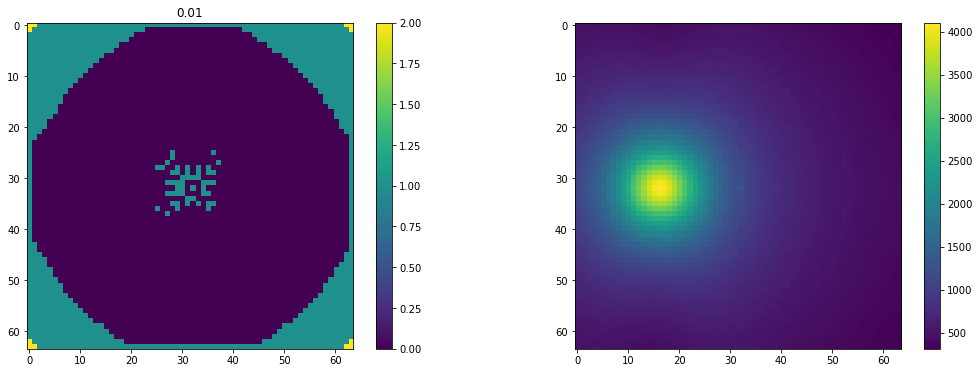

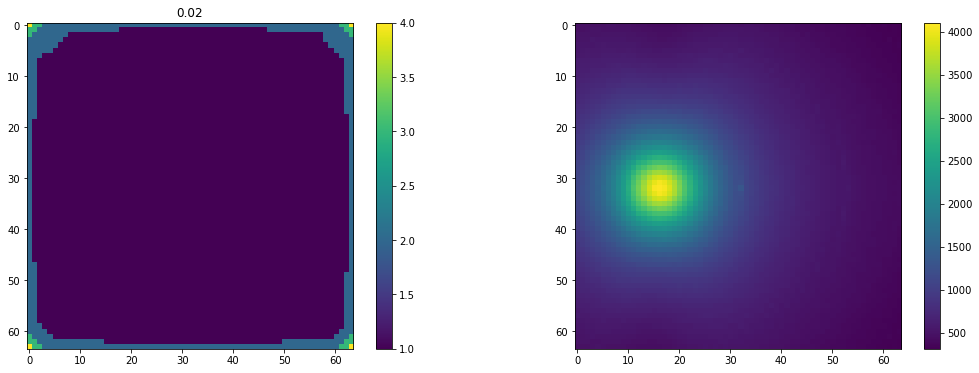

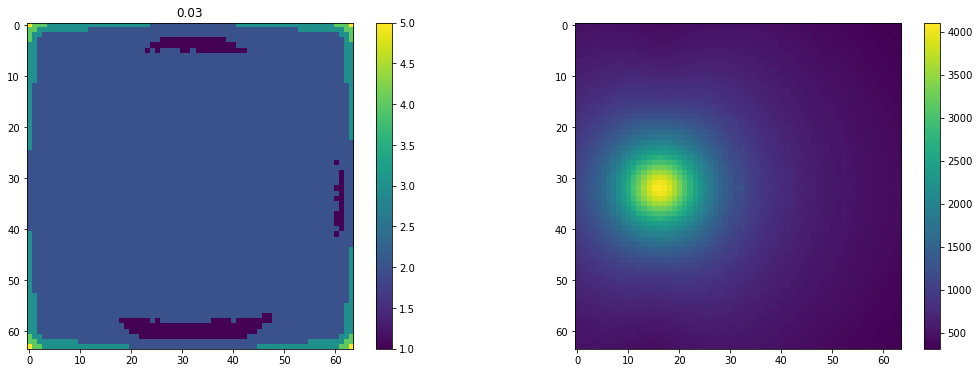

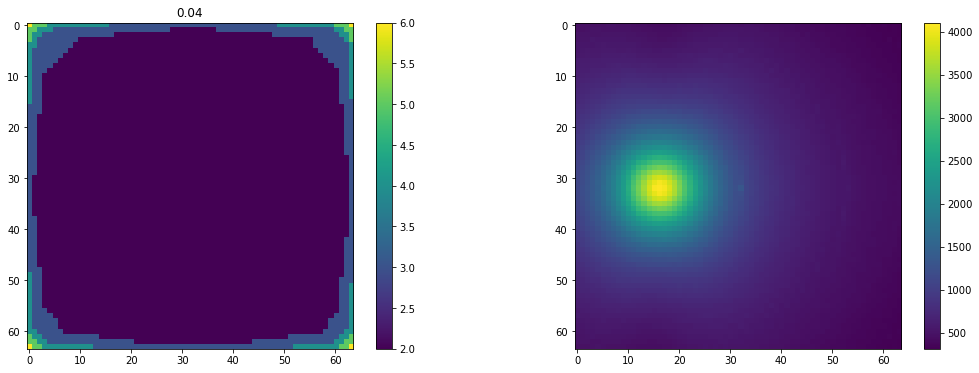

In [58]:
for percent in np.arange(0.01, 0.05, 0.01):
    localityMap = np.array([dist_covariance(Sigma, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

    p = np.array([16, 32])
    pid = p[1] * gridDimensions[1] + p[0]
    
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('{:g}'.format(percent))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(Sigma[pid,:].reshape(gridDimensions))
    plt.colorbar()
    plt.show()

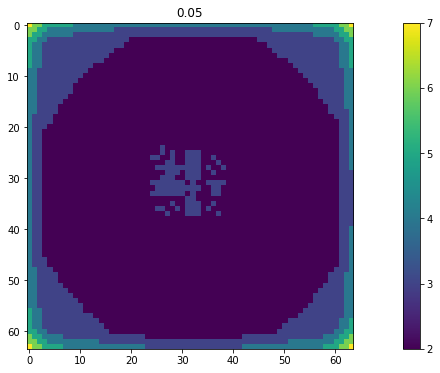

In [59]:
localityMap = np.array([dist_covariance(Sigma, p, 0.05) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

plt.figure(figsize=(18,6))
plt.title('{:g}'.format(0.05))
plt.imshow(localityMap)
plt.colorbar()
plt.show()